In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from imageio import imread
import re
from PIL import Image
import scipy
from scipy.spatial import distance
import math
from math import sqrt
from scipy.signal import savgol_filter, argrelextrema, find_peaks
from scipy.ndimage import gaussian_filter1d
from math import ceil
import clean_peaks

In [2]:
def sort_nicely( l ):
    # Sort the given list in the way that humans expect.
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    l.sort( key=alphanum_key )

In [3]:
# Lists with pathologies and subjects
pathologies = {'Diplegic': 'pat1', 'Hemiplegic': 'pat2', 'Neuropathic': 'pat3', 'Normal': 'normal', 'Parkinson': 'pat4'}

pat_dependencies = {'image_portion': {'Diplegic': 5, 'Hemiplegic': 5, 'Neuropathic': 4, 'Normal':5, 'Parkinson': 6}, 'peak_distance': {'Diplegic': 5, 'Hemiplegic': 5, 'Neuropathic': 5, 'Normal':5, 'Parkinson': 5}}

cameras = {'Camera 1': 'front_view', 'Camera 3': 'side_view'}

severity2lvl = {'s1': 'lvl1', 's2': 'lvl2', 'Normal': ''}

path = "/Users/pedroflores/Documents/IST/Tese/DATASETS/GAIT-IT-2_silhouettes2"

sequence_frames = {}

In [4]:
def pat_filter(step_width, pathology):
    if pathology == "Diplegic":
        step_width_smooth = gaussian_filter1d(step_width, 7.5)
    elif pathology == "Hemiplegic":
        step_width_smooth = gaussian_filter1d(step_width, 7)
    elif pathology == "Neuropathic":
        step_width_smooth = gaussian_filter1d(step_width, 7)
    elif pathology == "Normal":
        step_width_smooth = gaussian_filter1d(step_width, 4)
    elif pathology == "Parkinson":
        step_width_smooth = gaussian_filter1d(step_width, 5)
    return step_width_smooth

In [5]:
def plot_step_width(peaks, peaks_smooth, min_peaks_smooth, step_width, step_width_smooth, phases):

    print(peaks_smooth)
    # plt.plot(min_peaks, step_width[min_peaks], "o", color="red")
    plt.plot(min_peaks_smooth, step_width_smooth[min_peaks_smooth], "o", color="black")
    plt.plot(peaks, step_width[peaks], "x", color="blue")
    plt.plot(peaks_smooth, step_width_smooth[peaks_smooth], "o", color="red")
    plt.plot(phases, step_width_smooth[phases], "o", color="green")
    plt.plot(step_width)
    plt.plot(step_width_smooth)
    plt.show()

    even_idx = peaks_smooth[::2]
    for i in range(1,len(even_idx)):
        if even_idx[i] - even_idx[i-1] < 8:
            print("Gait cycle with less than 8 frames in " + sequencesPath)

    # Get distance between each consecutive peak
    peak_distances = []
    i = 0
    for x in peaks_smooth[1:]:
        peak_distances.append(x - peaks_smooth[i])
        i += 1

    # Check if any consecutive pair of peaks is less than 5 frames apart
    if any(np.array(peak_distances) < 5): print("Less than 5 frames between steps")

    # Check if there are less than 5 peaks in current sequence
    if len(peaks_smooth) < 5: print("Less than 5 peaks in sequence")

In [6]:
def gait_phases(peaks):

    # Initialize list to hold 9 point that separate each of the 8 gait phases
    phases = []

    # Iterate through peaks array, two at a time, to obtain each gait cycle
    for i in range(2, len(peaks), 2):

        # Determine number of frames in current gait cycle
        peak_diff = peaks[i]-peaks[i-2]

        # Determine frame at 60% of current cycle (0% - 60% = Stance phase)
        peak06 = round(peak_diff*0.6)
        
        # Determine number of frames from 60% to 100% of cycle (0% - 40% = Swing phase)
        peak04 = peak_diff - peak06

        # Stance phase 6 frames
        phase = [peaks[i-2] + round((peak06*j)/5) for j in range(0,6)]
        phases.extend(phase)

        # Swing phase 4 frames
        phase = [peaks[i-2] + peak06 + round((peak04*j)/3) for j in range(1,4)]
        phases.extend(phase)

        # Remove duplicates due to counting the same frame twice as last frame of a cycle and firts frame of next cycle
        phases = list(dict.fromkeys(phases))

    # Convert list to array
    phases = np.array(phases, dtype=int)
    
    return phases


In [7]:
def track_distances(sequencesPath, frames, pathology):

    # Read image files and store them in list
    imgs_array = [cv2.imread(os.path.join(sequencesPath, frame), 0) for frame in frames]

    # Initialize list of step width measurements
    step_width = []

    # Iterate through each frame
    for image in imgs_array:

        # Get lower portion of image to measure step width
        portion = pat_dependencies['image_portion'][pathology]
        
        # Rows from lower portion of image
        l_4 = (np.shape(image)[0]//portion)*(portion-1)

        # Get lower quarter of image
        image_l_4 = image[l_4:,:]  

        # Skip frame if foreground too small
        if sum(sum(image_l_4)) < 2000:
            continue

        # Mean across all columns and their indices
        column_means = image_l_4.mean(axis=0)
        nonzero_idx = np.nonzero(column_means)

        # Get first and last columns with active pixels
        f_c = nonzero_idx[0][0]
        l_c = nonzero_idx[0][-1]

        # # Draw rectangle around foreground and display
        # cv2.rectangle(image,(f_c,l_4),(l_c,np.shape(image)[0]), 255, thickness=2)
        # cv2.imshow('',image)
        # cv2.waitKey(100)

        # Get step width as the distance in the X axis between the leftmost and rightmost pixels
        step_width.append(l_c - f_c)
    
    # Smooth the step width plot to account for erratic peaks at the local maximums
    step_width_smooth = pat_filter(step_width, pathology)
    
    # Convert step width lists to arrays
    step_width = np.array(step_width)
    step_width_smooth = np.array(step_width_smooth)

    # Invert step width arrays to obtain minimum peaks
    inv_step_width = step_width*-1
    inv_step_width_smooth = step_width_smooth*-1

    # Compute maximum and minimum peaks in step width arrays
    peaks, _ = find_peaks(step_width, height=0, distance=pat_dependencies['peak_distance'][pathology])
    peaks_smooth, _ = find_peaks(step_width_smooth, height=0, distance=pat_dependencies['peak_distance'][pathology])
    min_peaks, _ = find_peaks(inv_step_width, height=None, distance=pat_dependencies['peak_distance'][pathology])
    min_peaks_smooth, _ = find_peaks(inv_step_width_smooth, height=None, distance=pat_dependencies['peak_distance'][pathology])

    # Clean specific peaks not caught by algorithm
    peaks_smooth = np.setdiff1d(peaks_smooth, clean_peaks.del_peaks(sequencesPath))
    peaks_smooth = np.append(peaks_smooth, clean_peaks.add_peaks(sequencesPath))
    peaks_smooth.sort()

    # Get 8 phases points between start and end of each gait cycle
    phases = gait_phases(peaks_smooth)
    print(phases)

    plot_step_width(peaks, peaks_smooth, min_peaks_smooth, step_width, step_width_smooth, phases)

    # return peaks_smooth
    return phases

/Users/pedroflores/Documents/IST/Tese/DATASETS/GAIT-IT-2_silhouettes2/Normal/s23/silhouettes/side_view/s23normal-1_back
[ 23  31  39  47  55  63  72  81  90  98 105 113 120 128 137 145 154]
[ 23  58  90 122 154 185]


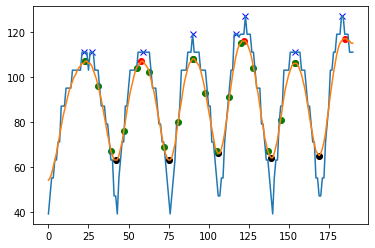

/Users/pedroflores/Documents/IST/Tese/DATASETS/GAIT-IT-2_silhouettes2/Normal/s23/silhouettes/side_view/s23normal-1_front
[26 33 41 48 56 63 71 80 88]
[ 26  57  88 120]


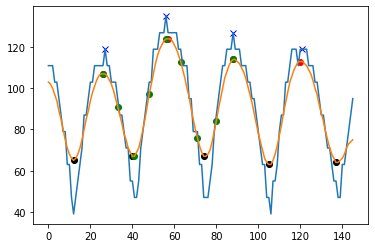

Less than 5 peaks in sequence
/Users/pedroflores/Documents/IST/Tese/DATASETS/GAIT-IT-2_silhouettes2/Normal/s23/silhouettes/side_view/s23normal-2_back
[ 38  46  55  63  72  80  89  99 108 116 124 131 139 147 156 164 173]
[ 38  75 108 140 173 205]


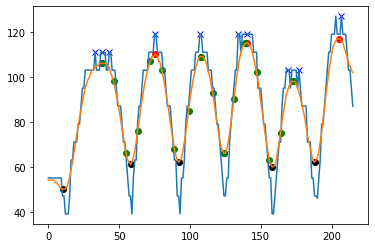

/Users/pedroflores/Documents/IST/Tese/DATASETS/GAIT-IT-2_silhouettes2/Normal/s23/silhouettes/side_view/s23normal-2_front
[ 26  34  41  49  56  64  72  81  89  96 104 111 119 126 134 143 151]
[ 26  58  89 120 151]


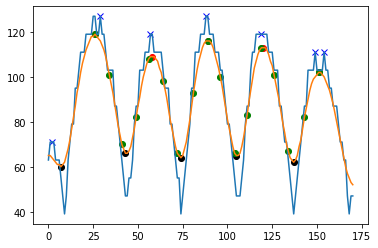

In [10]:
# Iterate through pathologies to access each pathology directory
for pathology in pathologies:

    if pathology not in ['Normal']: continue

    # Create folder path for each pathology in DATASETS directory
    pathology_dir = os.path.join(path, pathology)

    subs = [sub for sub in os.listdir(pathology_dir) if 'DS' not in sub]

    sort_nicely(subs)

    # Iterate folder for each subject in each pathology directory
    for sub in subs:

        if sub not in ['s23']: continue
        # ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12']
        # ['s13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 's22', 's23']

        # Get folder for subject
        sub_dir = os.path.join(pathology_dir, sub)

        # Get folder for binary silhouettes
        sub_dir_silhouettes = os.path.join(sub_dir, 'silhouettes')

        # Iterate folder for each view angle in the subject silhouettes directories
        for view in ['side_view']:

            # Silhouettes
            silhouettes_view_dir = os.path.join(sub_dir_silhouettes, view)

            # Obtain folders that hold each sequence
            sequence_folders = [folder for folder in os.listdir(silhouettes_view_dir) if 'DS' not in folder and '.txt' not in folder and '_' in folder]
            sort_nicely(sequence_folders)

            # Create directory for metadata files
            meta_folder = os.path.join(silhouettes_view_dir,'metadata')
            os.mkdir(meta_folder)

            # Initialize dictionary to hold key frames of each sequence
            phases_dict = {}
            # Iterate folder for each severity in the subject silhouettes directories
            for sequence_folder in sequence_folders:

                # Get sequence folders directories
                sequence_folder_dir = os.path.join(silhouettes_view_dir,sequence_folder)
                print(sequence_folder_dir)

                # Get binary silhouette sequences
                sequences = [sequence for sequence in os.listdir(sequence_folder_dir) if 'DS' not in sequence]
                sort_nicely(sequences)

                # Use track_distances() to obtain the frames that separate the 8 key phases in a gait cycle
                phases = track_distances(sequence_folder_dir, sequences, pathology)

                # Store key frames in a dictionary
                phases_dict[sequence_folder] = phases.tolist()
            
            # Save key frames dictionary as json file
            with open(meta_folder+'/key_frames.json','w') as f:
                json.dump(phases_dict,f)
